# Neural Networks

Copyright 2018 Wes Barnett

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

In [46]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io as sio
from scipy.optimize import minimize
%matplotlib inline

## 1 Neural networks
### 1.1 Model representation

![Neural network](neural-network.png)

In [47]:
input_layer_size = 400
hidden_layer_size = 25
num_labels = 10

In [48]:
df = sio.loadmat('ex4data1.mat')
X = df['X']
y = df['y']

### 1.2 Data visualization

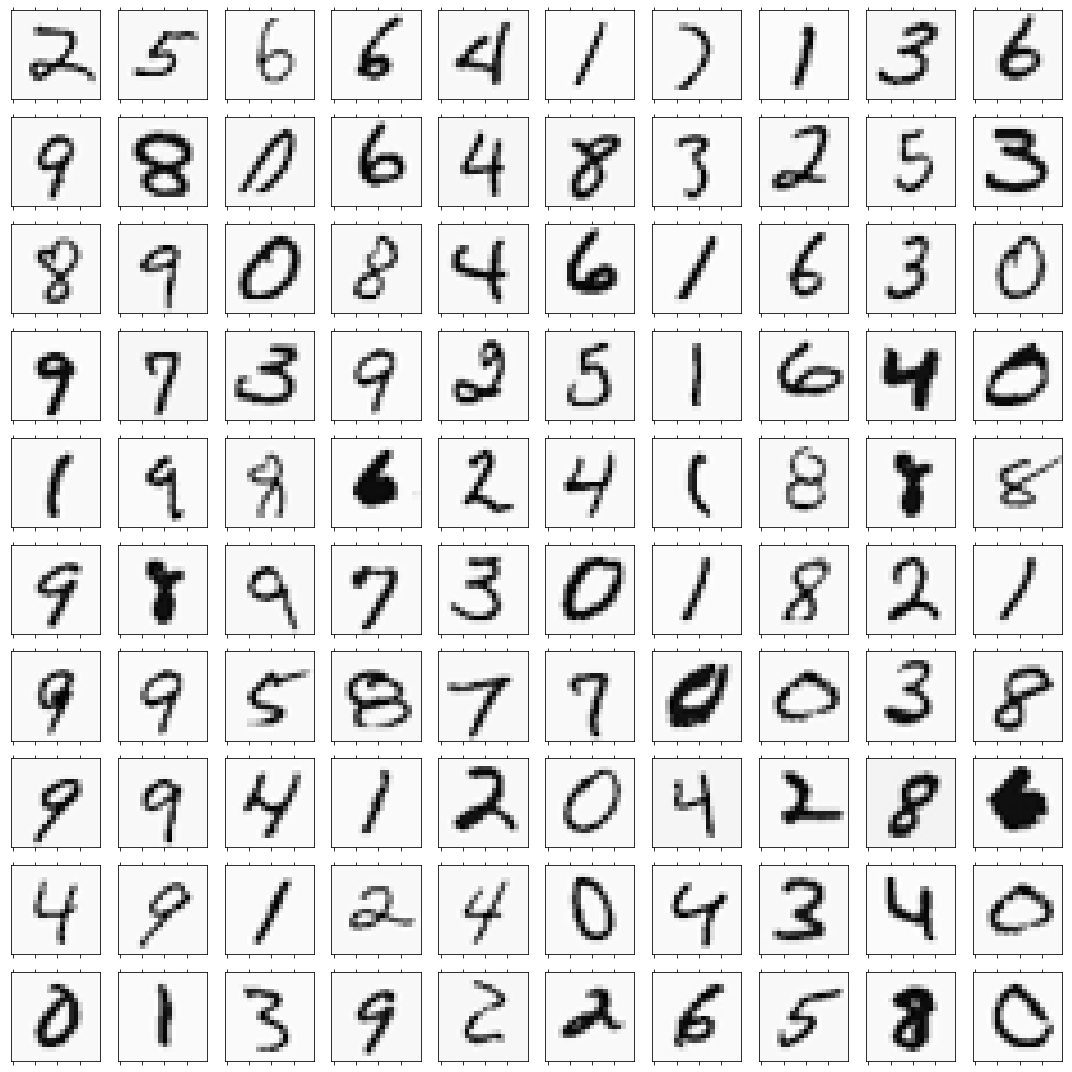

In [49]:
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for i, a in enumerate(ax.ravel()):
    j = np.random.randint(0,X.shape[0])
    a.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, 
                  left=False, labelleft=False)
    a.matshow(np.transpose(X[j,:].reshape(20,20)), cmap=plt.cm.Greys)
plt.tight_layout()

In [50]:
df_weights = sio.loadmat('ex4weights.mat')
Theta1 = df_weights["Theta1"]
Theta2 = df_weights["Theta2"]

In [51]:
nn_params = np.concatenate((Theta1.ravel(), Theta2.ravel()))

In [52]:
Theta1.shape

(25, 401)

In [53]:
Theta2.shape

(10, 26)

### 1.3 Feedforward and cost function

$J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K} \left [ -y_{k}^{(i)} \log{((h_{\theta}(x^{(i)}))_{k})} - (1 - y_{k}^{(i)})\log{(1 - h_{\theta}(x^{(i)}))_{k})}\right ] + $

$\frac{\lambda}{2m} \left [  \sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta^{(1)}_{j,k})^{2} + \sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta^{(2)}_{j,k})^{2} \right ]$

In [54]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, l):
    nn_params = nn_params.reshape(-1,1)
    Theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], 
                       (hidden_layer_size, (input_layer_size+1)))
    Theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], 
                       (num_labels, hidden_layer_size+1))
    
    m = X.shape[0]
    J = 0.
    
    a1 = np.hstack((np.ones((m,1)), X))    
    z2 = np.matmul(Theta1, a1.transpose())
    a2 = np.hstack((np.ones((m,1)), sigmoid(z2).transpose()))
    z3 = np.matmul(Theta2, a2.transpose())
    h = sigmoid(z3)

    J = np.sum( -y*np.log(h) - (1.-y)*np.log(1.-h) ) / m
    J += l*0.5/m * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))

    return J

In [55]:
# Onehot encode the labels, which go from 1 to 10 (10 represents 0 in this dataset)
# The weights were pretrained so we need to use the same convention here
yk = (y == np.arange(1,num_labels+1)).astype(int).transpose()
yk.shape

(10, 5000)

In [56]:
# Expect 0.287629
l = 0.
nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, yk, l)

0.28762916516131887

In [57]:
# Expect 0.383770
l = 1.
nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, yk, l)

0.3837698590909236

## 2 Back propogation

In [58]:
def sigmoidGradient(z):
    return sigmoid(z) * (1. - sigmoid(z))

def nnGradFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, y, l):
    nn_params = nn_params.reshape(-1,1)
    Theta1 = np.reshape(nn_params[:hidden_layer_size*(input_layer_size+1)], 
                       (hidden_layer_size, (input_layer_size+1)))
    Theta2 = np.reshape(nn_params[hidden_layer_size*(input_layer_size+1):], 
                       (num_labels, hidden_layer_size+1))
    
    m = X.shape[0]
    J = 0.
    Theta1_grad = np.zeros(Theta1.shape)
    Theta2_grad = np.zeros(Theta2.shape)
    Delta1 = np.zeros(Theta1.shape)
    Delta2 = np.zeros(Theta2.shape)
    
    for t in range(m):
        a1 = np.hstack((1.0, X[t,:].transpose()))
        z2 = np.matmul(Theta1, a1)
        a2 = np.hstack((1.0, sigmoid(z2)))
        z3 = np.matmul(Theta2, a2)
        a3 = sigmoid(z3)
        
        d3 = a3 - y[:,t]
        d2 = np.matmul(Theta2[:,1:].transpose(), d3) * sigmoidGradient(z2)
        
        a2 = a2.reshape(-1,1)
        a1 = a1.reshape(-1,1)
        d3 = d3.reshape(-1,1)
        d2 = d2.reshape(-1,1)
        
        Delta2 = Delta2 + np.matmul(d3, a2.transpose())
        Delta1 = Delta1 + np.matmul(d2, a1.transpose())
        
    Theta1_grad = Delta1 / m
    Theta2_grad = Delta2 / m
    
    Theta1_grad[:,1:] += Theta1[:,1:]*l/m
    Theta2_grad[:,1:] += Theta2[:,1:]*l/m
 
    return np.concatenate((Theta1_grad.ravel(), Theta2_grad.ravel()))

In [59]:
def debugInitializeWeights(fan_out, fan_in):
    W = np.zeros((fan_out, 1+fan_in))
    W = np.sin(np.arange(W.size)).reshape(W.shape) / 10.
    return W

def computeNumericalGradient(theta, input_layer_size, hidden_layer_size, num_labels, X, y, l):
    numgrad = np.zeros(theta.shape)
    perturb = np.zeros(theta.shape)
    e = 1e-4
    for p in range(theta.size):
        perturb[p] = e
        loss1 = nnCostFunction(theta - perturb, input_layer_size, hidden_layer_size, num_labels, X, y, l)
        loss2 = nnCostFunction(theta + perturb, input_layer_size, hidden_layer_size, num_labels, X, y, l)
        numgrad[p] = (loss2 - loss1) / (2.*e)
        perturb[p] = 0.
    return numgrad

# Construct a small neural network to check backpropogation
def checkNNGradients(l=0.):
    input_layers_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size).reshape(-1,1)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size).reshape(-1,1)
    X = debugInitializeWeights(m, input_layer_size - 1)
    y = 1. + np.mod(np.arange(m), num_labels).reshape(-1,1)
    yk = (y == np.arange(1,num_labels+1)).astype(int).transpose()
    nn_params = np.concatenate((Theta1.ravel(), Theta2.ravel()))
    grad = nnGradFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, yk, l)
    numgrad = computeNumericalGradient(nn_params, input_layer_size, hidden_layer_size, num_labels, X, yk, l)
    print(grad)
    print(numgrad)
    diff = np.sqrt(np.sum((numgrad - grad)**2)) / np.sqrt(np.sum((numgrad + grad)**2))
    print(diff)

In [60]:
# Gradient from gradient function and numerically calculated gradient should be nearly the same
checkNNGradients()

[4.46367976e-03 8.10123966e-05 2.71261320e-05 ... 2.71567118e-01
 1.76385657e-01 6.77219697e-02]
[4.46367976e-03 8.10124012e-05 2.71261302e-05 ... 2.71567118e-01
 1.76385657e-01 6.77219697e-02]
6.876439528702047e-11


In [61]:
checkNNGradients(3.0)

[0.00446368 0.05056927 0.05458497 ... 0.31058439 0.15911146 0.01003812]
[0.00446368 0.05056927 0.05458497 ... 0.31058439 0.15911146 0.01003812]
3.6712569102062796e-11


In [62]:
# Expect 0.576051
l = 3.
nnCostFunction(nn_params, input_layer_size, hidden_layer_size, num_labels, X, yk, l)

0.5760512469501331

In [63]:
def randInitialWeights(L_in, L_out):
    W = np.zeros((L_out, 1+L_in))
    epsilon_init = 0.12
    W = np.random.rand(L_out, 1+L_in)*2.*epsilon_init - epsilon_init
    return W

In [64]:
initial_Theta1 = randInitialWeights(input_layer_size, hidden_layer_size)
initial_Theta2 = randInitialWeights(hidden_layer_size, num_labels)
initial_nn_params = np.concatenate((initial_Theta1.ravel(), initial_Theta2.ravel()))

In [65]:
l = 3.
theta_result = minimize(nnCostFunction, initial_nn_params, method="CG", jac=nnGradFunction,
                        args=(input_layer_size, hidden_layer_size, num_labels, X, yk, l), 
                        options={"maxiter": 50})

In [66]:
Theta1 = np.reshape(theta_result.x[:hidden_layer_size*(input_layer_size+1)],
                    (hidden_layer_size, (input_layer_size+1)))
Theta2 = np.reshape(theta_result.x[hidden_layer_size*(input_layer_size+1):], 
                    (num_labels, hidden_layer_size+1))

In [67]:
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    num_labels = Theta2.shape[0]
    h1 = sigmoid(np.matmul(np.hstack(( np.ones((m,1)), X)), Theta1.transpose() ))
    h2 = sigmoid(np.matmul(np.hstack(( np.ones((m,1)), h1)), Theta2.transpose() ))
    # Since the encoding was done such that the first argument (argument zero) corresponds to one,
    # and so on, we need to add one to this
    return np.argmax(h2, axis=1)+1

In [68]:
np.mean(predict(Theta1, Theta2, X) == y.transpose())

0.9536

## 3 Keras

In [75]:
from keras.models import Sequential
from keras.layers import Dense
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta
from keras.utils import to_categorical
from keras.metrics import categorical_accuracy

In [70]:
def baseline_model(batch_size=1, epochs=1):
    model = Sequential()
    model.add(Dense(25, input_dim=400, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss=categorical_crossentropy,
                  optimizer=Adadelta(), 
                  metrics=['accuracy'])
    return model

In [71]:
model = baseline_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 25)                10025     
_________________________________________________________________
dense_12 (Dense)             (None, 10)                260       
Total params: 10,285
Trainable params: 10,285
Non-trainable params: 0
_________________________________________________________________


In [81]:
model.fit(X, yk.transpose(), batch_size=1, epochs=1, verbose=1)

Epoch 1/1
5000/5000 [==============================] - 7s 1ms/step - loss: 0.0365 - acc: 0.9900


In [82]:
# TODO: regularization
# TODO: score